<a href="https://colab.research.google.com/github/Arth1206/Hello_World/blob/master/Unet_neil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib.pyplot import imshow
from scipy.ndimage import rotate
import glob

import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" #for training on gpu
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
train_x = np.load('gdrive/My Drive/Google Colab/Codes/Data/train_x.npy')
train_y = np.load('gdrive/My Drive/Google Colab/Codes/Data/train_y.npy')

test_x = np.load('gdrive/My Drive/Google Colab/Codes/Data/test_x.npy')
test_y = np.load('gdrive/My Drive/Google Colab/Codes/Data/test_y.npy')

(4504, 128, 128, 3)
(4504, 128, 128, 3)
(90, 128, 128, 3)
(90, 128, 128, 3)


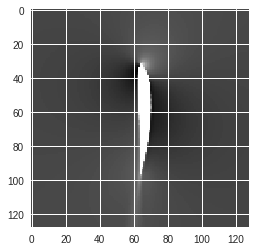

In [4]:
print(train_y.shape)
print(train_x.shape)
print(test_y.shape)
print(test_x.shape)
%matplotlib inline
imshow(train_y[10,:,:,1])

In [0]:
train_x_min = train_x.min(axis=(0, 1, 2), keepdims=True)
train_x_max = train_x.max(axis=(0, 1, 2), keepdims=True)
train_y_min = train_y.min(axis=(0, 1, 2), keepdims=True)
train_y_max = train_y.max(axis=(0, 1, 2), keepdims=True)

In [6]:
train_x_min.shape, train_y_min.shape

((1, 1, 1, 3), (1, 1, 1, 3))

In [0]:
train_x_norm = (train_x - train_x_min)/(train_x_max - train_x_min)
train_y_norm = (train_y - train_y_min)/(train_y_max - train_y_min)

test_x_norm = (test_x - train_x_min)/(train_x_max - train_x_min)
test_y_norm = (test_y - train_y_min)/(train_y_max - train_y_min)

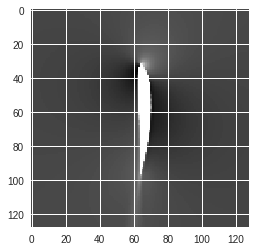

In [8]:
%matplotlib inline
imshow(train_y_norm[10,:,:,1])

In [0]:
training_iters = 5000
batch_size = 10

In [0]:
is_training = tf.placeholder(tf.bool, name="is_training")
keep_prob = tf.placeholder(tf.float32)
x = tf.placeholder(tf.float32, [None, 128, 128, 3])
y = tf.placeholder(tf.float32, [None, 128, 128, 3])
lr = tf.placeholder(tf.float32)

In [11]:
weights = {
    
    'w1': tf.get_variable('W0', shape=(4,4,3,64), initializer=tf.contrib.layers.xavier_initializer()), 
    'w2': tf.get_variable('W1', shape=(4,4,64,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'w2b': tf.get_variable('W2', shape=(4,4,128,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'w3': tf.get_variable('W3', shape=(4,4,128,256), initializer=tf.contrib.layers.xavier_initializer()),
    'w4': tf.get_variable('W4', shape=(2,2,256,512), initializer=tf.contrib.layers.xavier_initializer()),
    'w5': tf.get_variable('W5', shape=(2,2,512,512), initializer=tf.contrib.layers.xavier_initializer()),
    'w6': tf.get_variable('W6', shape=(2,2,512,512), initializer=tf.contrib.layers.xavier_initializer()),
    
    'dw6': tf.get_variable('DW6', shape=(1,1,512,512), initializer=tf.contrib.layers.xavier_initializer()),
    'dw5': tf.get_variable('DW5', shape=(1,1,1024,512), initializer=tf.contrib.layers.xavier_initializer()),
    'dw4': tf.get_variable('DW4', shape=(1,1,1024,256), initializer=tf.contrib.layers.xavier_initializer()),
    'dw3': tf.get_variable('DW3', shape=(3,3,512,128), initializer=tf.contrib.layers.xavier_initializer()),
    'dw2b': tf.get_variable('DW2', shape=(3,3,256,128), initializer=tf.contrib.layers.xavier_initializer()),
    'dw2': tf.get_variable('DW1', shape=(3,3,256,64), initializer=tf.contrib.layers.xavier_initializer()),
    'dw1': tf.get_variable('DW0', shape=(4,4,3,128), initializer=tf.contrib.layers.xavier_initializer()),
}

biases = {
    
    'b1': tf.get_variable('B0', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'b2': tf.get_variable('B1', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'b2b': tf.get_variable('B2', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'b3': tf.get_variable('B3', shape=(256), initializer=tf.contrib.layers.xavier_initializer()),
    'b4': tf.get_variable('B4', shape=(512), initializer=tf.contrib.layers.xavier_initializer()),
    'b5': tf.get_variable('B5', shape=(512), initializer=tf.contrib.layers.xavier_initializer()),
    'b6': tf.get_variable('B6', shape=(512), initializer=tf.contrib.layers.xavier_initializer()),
    
    'db6': tf.get_variable('DB6', shape=(512), initializer=tf.contrib.layers.xavier_initializer()),
    'db5': tf.get_variable('DB5', shape=(512), initializer=tf.contrib.layers.xavier_initializer()),
    'db4': tf.get_variable('DB4', shape=(256), initializer=tf.contrib.layers.xavier_initializer()),
    'db3': tf.get_variable('DB3', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'db2b': tf.get_variable('DB2', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'db2': tf.get_variable('DB1', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'db1': tf.get_variable('DB0', shape=(3), initializer=tf.contrib.layers.xavier_initializer()),
}

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
#Output1
out1_1 = tf.nn.conv2d(x, weights['w1'], strides=[1, 2, 2, 1], padding='SAME')
out1 = tf.nn.bias_add(out1_1, biases['b1'])

#Output2
out2_1 = tf.nn.leaky_relu(out1, alpha=0.2)
out2_2 = tf.nn.conv2d(out2_1, weights['w2'], strides=[1, 2, 2, 1], padding='SAME')
out2_3 = tf.nn.bias_add(out2_2, biases['b2'])
out2_4 = tf.layers.batch_normalization(out2_3,training=is_training)
out2 = tf.nn.dropout(out2_4, keep_prob)

#Output2b
out2b_1 = tf.nn.leaky_relu(out2, alpha=0.2)
out2b_2 = tf.nn.conv2d(out2b_1, weights['w2b'], strides=[1, 2, 2, 1], padding='SAME')
out2b_3 = tf.nn.bias_add(out2b_2, biases['b2b'])
out2b_4 = tf.layers.batch_normalization(out2b_3,training=is_training)
out2b = tf.nn.dropout(out2b_4, keep_prob)

#Output3
out3_1 = tf.nn.leaky_relu(out2b, alpha=0.2)
out3_2 = tf.nn.conv2d(out3_1, weights['w3'], strides=[1, 2, 2, 1], padding='SAME')
out3_3 = tf.nn.bias_add(out3_2, biases['b3'])
out3_4 = tf.layers.batch_normalization(out3_3,training=is_training)
out3 = tf.nn.dropout(out3_4, keep_prob)

#Output4
out4_1 = tf.nn.leaky_relu(out3, alpha=0.2)
out4_2 = tf.nn.conv2d(out4_1, weights['w4'], strides=[1, 2, 2, 1], padding='SAME')
out4_3 = tf.nn.bias_add(out4_2, biases['b4'])
out4_4 = tf.layers.batch_normalization(out4_3,training=is_training)
out4 = tf.nn.dropout(out4_4, keep_prob)

#Output5
out5_1 = tf.nn.leaky_relu(out4, alpha=0.2)
out5_2 = tf.nn.conv2d(out5_1, weights['w5'], strides=[1, 2, 2, 1], padding='SAME')
out5_3 = tf.nn.bias_add(out5_2, biases['b5'])
out5_4 = tf.layers.batch_normalization(out5_3,training=is_training)
out5 = tf.nn.dropout(out5_4, keep_prob)

#Output6
out6_1 = tf.nn.leaky_relu(out5, alpha=0.2)
out6_2 = tf.nn.conv2d(out6_1, weights['w6'], strides=[1, 2, 2, 1], padding='SAME')
out6_3 = tf.nn.bias_add(out6_2, biases['b6'])
out6 = tf.nn.dropout(out6_3, keep_prob)

#Deconvolutional Output 6
dout6_1 = tf.nn.relu(out6)
dout6_2 = tf.image.resize_bilinear(dout6_1, [2,2])
dout6_3 = tf.nn.conv2d(dout6_2, weights['dw6'], strides=[1, 1, 1, 1], padding='SAME')
dout6_4 = tf.nn.bias_add(dout6_3, biases['db6'])
dout6_5 = tf.layers.batch_normalization(dout6_4,training=is_training)
dout6 = tf.nn.dropout(dout6_5, keep_prob)
#Concat dout6 and out5
dout6_out5 = tf.concat([dout6,out5], axis = 3)

#Deconvolutional Output 5
dout5_1 = tf.nn.relu(dout6_out5)
dout5_2 = tf.image.resize_bilinear(dout5_1, [4,4])
dout5_3 = tf.nn.conv2d(dout5_2, weights['dw5'], strides=[1, 1, 1, 1], padding='SAME')
dout5_4 = tf.nn.bias_add(dout5_3, biases['db5'])
dout5_5 = tf.layers.batch_normalization(dout5_4,training=is_training)
dout5 = tf.nn.dropout(dout5_5, keep_prob)
#Concat dout5 and out4
dout5_out4 = tf.concat([dout5,out4], axis = 3)

#Deconvolutional Output 4
dout4_1 = tf.nn.relu(dout5_out4)
dout4_2 = tf.image.resize_bilinear(dout4_1, [8,8])
dout4_3 = tf.nn.conv2d(dout4_2, weights['dw4'], strides=[1, 1, 1, 1], padding='SAME')
dout4_4 = tf.nn.bias_add(dout4_3, biases['db4'])
dout4_5 = tf.layers.batch_normalization(dout4_4,training=is_training)
dout4 = tf.nn.dropout(dout4_5, keep_prob)
#Concat dout4 and out3
dout4_out3 = tf.concat([dout4,out3], axis = 3)

#Deconvolutional Output 3
dout3_1 = tf.nn.relu(dout4_out3)
dout3_2 = tf.image.resize_bilinear(dout3_1, [16,16])
dout3_3 = tf.nn.conv2d(dout3_2, weights['dw3'], strides=[1, 1, 1, 1], padding='SAME')
dout3_4 = tf.nn.bias_add(dout3_3, biases['db3'])
dout3_5 = tf.layers.batch_normalization(dout3_4,training=is_training)
dout3 = tf.nn.dropout(dout3_5, keep_prob)
#Concat dout3 and out2b
dout3_out2b = tf.concat([dout3,out2b], axis = 3)

#Deconvolutional Output 2b
dout2b_1 = tf.nn.relu(dout3_out2b)
dout2b_2 = tf.image.resize_bilinear(dout2b_1, [32,32])
dout2b_3 = tf.nn.conv2d(dout2b_2, weights['dw2b'], strides=[1, 1, 1, 1], padding='SAME')
dout2b_4 = tf.nn.bias_add(dout2b_3, biases['db2b'])
dout2b_5 = tf.layers.batch_normalization(dout2b_4,training=is_training)
dout2b = tf.nn.dropout(dout2b_5, keep_prob)
#Concat dout2b and out2
dout2b_out2 = tf.concat([dout2b,out2], axis = 3)

#Deconvolutional Output 2
dout2_1 = tf.nn.relu(dout2b_out2)
dout2_2 = tf.image.resize_bilinear(dout2_1, [64,64])
dout2_3 = tf.nn.conv2d(dout2_2, weights['dw2'], strides=[1, 1, 1, 1], padding='SAME')
dout2_4 = tf.nn.bias_add(dout2_3, biases['db2'])
dout2_5 = tf.layers.batch_normalization(dout2_4,training=is_training)
dout2 = tf.nn.dropout(dout2_5, keep_prob)
#Concat dout2 and out1
dout2_out1 = tf.concat([dout2,out1], axis = 3)

#Deconvolutional Output 1
dout1_1 = tf.nn.relu(dout2_out1)
dout1_2 = tf.nn.conv2d_transpose(dout1_1, weights['dw1'], [batch_size,128, 128, 3], [1,2,2,1], padding='SAME')
dout1 = tf.nn.bias_add(dout1_2, biases['db1'])

Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
dout1.shape

TensorShape([Dimension(10), Dimension(128), Dimension(128), Dimension(3)])

In [14]:
loss = tf.losses.sigmoid_cross_entropy(y, dout1)
optimizer = tf.train.AdamOptimizer(learning_rate = lr, beta1=0.5, beta2=0.999).minimize(loss)

Instructions for updating:
Use tf.cast instead.


In [0]:
# init

saver = tf.train.Saver()
init = tf.global_variables_initializer()

loss_array = np.zeros(training_iters)

with tf.Session() as sess:
  
  sess.run(init)
  
  for i in range(training_iters):
    
    for batch in range(len(train_x_norm)//batch_size):
      
      batch_x = train_x_norm[batch*batch_size:min((batch+1)*batch_size,len(train_x_norm))]
      batch_y = train_y_norm[batch*batch_size:min((batch+1)*batch_size,len(train_y_norm))]
      
      feed_dict = {x: batch_x, y: batch_y, lr: 0.0004, keep_prob: 0.99, is_training: True}
      loss_value, _ = sess.run([loss, optimizer], feed_dict=feed_dict)
    
    loss_array[i] = loss_value
    
    print("Epoch no: ", i, " Cost: ", loss_value)
    
    if i%200 == 0:
      
      saver.save(sess, 'gdrive/My Drive/Google Colab/saved_models/my_model', global_step = i, write_meta_graph=False)
      
      plt.plot(loss_array)
      plt.xlabel('No of Iterations')
      plt.ylabel('Loss')

Epoch no:  0  Cost:  0.67380154
Epoch no:  1  Cost:  0.6732178
Epoch no:  2  Cost:  0.6728545
Epoch no:  3  Cost:  0.672679
Epoch no:  4  Cost:  0.67251724
Epoch no:  5  Cost:  0.6724219
Epoch no:  6  Cost:  0.672326
Epoch no:  7  Cost:  0.67225146
Epoch no:  8  Cost:  0.6722309
Epoch no:  9  Cost:  0.6721074
Epoch no:  10  Cost:  0.67211366
Epoch no:  11  Cost:  0.67206675
Epoch no:  12  Cost:  0.672013
Epoch no:  13  Cost:  0.6719229
Epoch no:  14  Cost:  0.6718901
Epoch no:  15  Cost:  0.67192906
Epoch no:  16  Cost:  0.67188
Epoch no:  17  Cost:  0.6718234
Epoch no:  18  Cost:  0.6718037
Epoch no:  19  Cost:  0.6718234
Epoch no:  20  Cost:  0.6716986
Epoch no:  21  Cost:  0.6717941
Epoch no:  22  Cost:  0.67170894
Epoch no:  23  Cost:  0.67189336
Epoch no:  24  Cost:  0.6717055
Epoch no:  25  Cost:  0.67168266
Epoch no:  26  Cost:  0.67171645
Epoch no:  27  Cost:  0.67184716
Epoch no:  28  Cost:  0.6716141
Epoch no:  29  Cost:  0.6715939
Epoch no:  30  Cost:  0.67174757
Epoch no:  

In [0]:
#relative error
test_x_norm = (test_x - train_x_min)/(train_x_max - train_x_min)
test_y_norm = (test_y - train_y_min)/(train_y_max - train_y_min)
#create 2 new arrays matching test_y
test_y_hat = np.zeros_like(test_y_norm)
test_y_abs_error = np.zeros_like(test_y_norm)
#first array is for predicted values test_y_hat
with tf.Session() as sess:
  sess.run(init)
  test_y_hat = sess.run([deconv7], feed_dict={x: test_x_norm})
#second arrays if for absolute difference between target value and prediction test_y_abs_error
test_y_abs_error = np.abs(test_y_norm-test_y_hat)
# precentage loss by ratio of means which is same as the ratio of the sum
loss_per = np.sum(test_y_abs_error)/np.sum(np.abs(test_y_norm))



In [0]:
with tf.Session() as sess:
  
  saver.restore(sess, 'gdrive/My Drive/Google Colab/saved_models/my_model-1000')
  
  for batch in range(len(test_x_norm)//batch_size):
      
      batch_x = test_x_norm[batch*batch_size:min((batch+1)*batch_size,len(test_x_norm))]
      test_y_hat[batch*batch_size:min((batch+1)*batch_size,len(test_x_norm))] = sess.run([dout1], feed_dict={x: batch_x, is_training: False, keep_prob: 1})
  
from numpy import array
test_y_hat = array(test_y_hat)
test_y_hat = np.squeeze(test_y_hat)
  
#second arrays if for absolute difference between target value and prediction test_y_abs_error
test_y_abs_error = np.abs(test_y_norm-test_y_hat)

# percentage loss by ratio of means which is same as the ratio of the sum
loss_per = np.sum(test_y_abs_error)/np.sum(np.abs(test_y_norm))
  

In [0]:
imshow(test_y_norm[10,:,:,1])

In [0]:
imshow(test_y_hat[10,:,:,1])

In [0]:
imshow(test_y_abs_error[10,:,:,1])